# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
import astropy.constants as const
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import copy
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
from matplotlib.colors import SymLogNorm

from minot.ClusterTools import map_tools
from minot.ClusterTools import cluster_global
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
outdir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Define the models

### Common parameters

In [3]:
NR500_trunc = 3
redshift    = 0.017284
M500        = 6.2e14*u.Msun
RA          = 49.950667*u.deg
Dec         = 41.511696*u.deg

cor_chu2003 = 50.0/cosmo.H0.to_value('km s-1 Mpc-1')

In [4]:
C0 = minot.Cluster(name='', redshift=redshift, M500=M500, RA=RA, Dec=Dec, cosmology=cosmo, silent=True, output_dir=outdir)
C0.R_truncation = NR500_trunc*C0.R500

C0.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':59*u.kpc, 'n_01':0.045*u.cm**-3,'beta2':0.71, 'r_c2':287*u.kpc, 'n_02':0.0035*u.cm**-3}

radius = np.logspace(0,5,1000)*u.kpc
T_e = 7.0*(1+(radius.to_value('kpc')/(100.0*cor_chu2003))**3)/(2.3+(radius.to_value('kpc')/(100.0*cor_chu2003))**3)*u.keV * (1+(radius.to_value('Mpc')/1.6)**1.7)**-(2.0/2)
n_e = C0.get_density_gas_profile(radius)[1]
P_e = n_e*T_e
C0.pressure_gas_model = {'name':'User', 'radius':radius, 'profile':P_e}

### Taylor direct measurement + 2/3 scaling

In [5]:
C1 = copy.deepcopy(C0)
C1.name = r'Taylor (2006) + $\eta=2/3$'

radius = np.logspace(0,5,1000)*u.kpc
C1.set_magfield_isodens_scal_param(Bnorm=1*u.uG, r0=10*u.kpc, scal=1.0)
r, B = C1.get_magfield_profile(radius)
r_ref, B_ref = C1.get_magfield_profile(10*u.kpc)
C1.magfield_model = {'name':'User', 'radius':radius, 'profile':25*u.uG*(B/B_ref[0])**(2.0/3)}

### Walker KHI

In [6]:
C2 = copy.deepcopy(C0)
C2.name = 'Walker (2017)'

radius = np.logspace(0,5,1000)*u.kpc
r, P = C2.get_pressure_gas_profile(radius)
mu_gas,mu_e,mu_p,mu_alpha = cluster_global.mean_molecular_weight(Y=C2.helium_mass_fraction,Z=C2.metallicity_sol*C2.abundance)
B = (2*const.mu0*(mu_e/mu_gas)*P/200)**0.5
C2.magfield_model = {'name':'User', 'radius':radius, 'profile':B}

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


### Bonafede 2010 + Coma scaling best

In [7]:
n0_coma = 3.36e-3*u.cm**-3

In [8]:
C3 = copy.deepcopy(C0)
C3.name = r'Bonafede (2010, Coma) + best $\eta$ scaling'

radius = np.logspace(0,5,1000)*u.kpc
n_e = C3.get_density_gas_profile(radius)[1]
C3.magfield_model = {'name':'User', 'radius':radius, 'profile':4.7*u.uG * ((n_e/n0_coma).to_value(''))**0.5}

### Bonafede 2010 + Coma scaling LL

In [9]:
C4 = copy.deepcopy(C0)
C4.name = r'Bonafede (2010, Coma) + lower $\eta$ scaling'

radius = np.logspace(0,5,1000)*u.kpc
n_e = C4.get_density_gas_profile(radius)[1]
C4.magfield_model = {'name':'User', 'radius':radius, 'profile':3.9*u.uG * ((n_e/n0_coma).to_value(''))**0.4}

### Bonafede 2010 + Coma scaling UL

In [10]:
C5 = copy.deepcopy(C0)
C5.name = 'Bonafede (2010, Coma) + upper $\eta$ scaling'

radius = np.logspace(0,5,1000)*u.kpc
n_e = C4.get_density_gas_profile(radius)[1]
C5.magfield_model = {'name':'User', 'radius':radius, 'profile':5.4*u.uG * ((n_e/n0_coma).to_value(''))**0.9}

### Bonafede 2010 + Coma scaling 2/3

In [11]:
C6 = copy.deepcopy(C0)
C6.name = 'Bonafede (2010, Coma) + $\eta=2/3$ scaling'

radius = np.logspace(0,5,1000)*u.kpc
n_e = C6.get_density_gas_profile(radius)[1]
C6.magfield_model = {'name':'User', 'radius':radius, 'profile':5.0*u.uG * ((n_e/n0_coma).to_value(''))**(2.0/3)}

# Comparison

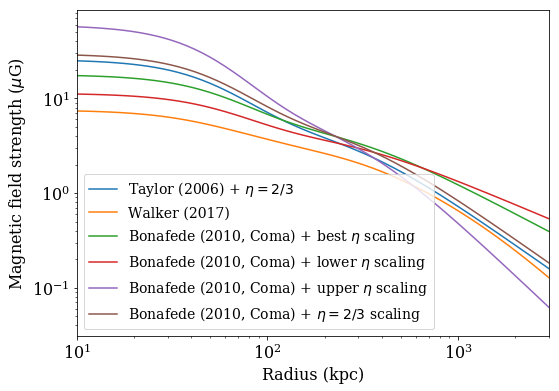

In [14]:
fig = plt.figure(0, figsize=(8, 6))
r, B = C1.get_magfield_profile()
plt.loglog(r,B, label=C1.name)
r, B = C2.get_magfield_profile()
plt.loglog(r,B, label=C2.name)
r, B = C3.get_magfield_profile()
plt.loglog(r,B, label=C3.name)
r, B = C4.get_magfield_profile()
plt.loglog(r,B, label=C4.name)
r, B = C5.get_magfield_profile()
plt.loglog(r,B, label=C5.name)
r, B = C6.get_magfield_profile()
plt.loglog(r,B, label=C6.name)
plt.xlabel('Radius (kpc)')
plt.ylabel('Magnetic field strength ($\\mu$G)')
plt.xlim(10,3000)
plt.legend(loc='lower left', fontsize=14)
plt.savefig(C0.output_dir+'/MagneticFieldModels.pdf')